I first import the necessary packages

In [ ]:
!conda install -c conda-forge geopandas -y
!pip install libpysal esda spreg

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import libpysal
from esda.moran import Moran
from spreg import ML_Lag
import numpy as np

print("packages imported")

packages imported


I then imported the data files I found on US Census Bureau. I use the US County shapefile and DP03 Selected Economic Characteristics dataset. I plotted the shapefile and also wanted to take a look at what the datasets look like.

In [3]:
gdf = gpd.read_file('/Users/berkeelibol/Downloads/tl_2025_us_county/tl_2025_us_county.shp')

df = pd.read_csv('/Users/berkeelibol/Downloads/ACSDP5Y2023.DP03_2025-12-28T142046/ACSDP5Y2023.DP03-Data.csv', low_memory= False)
df = df.iloc[1:]

print("data imported")

data imported


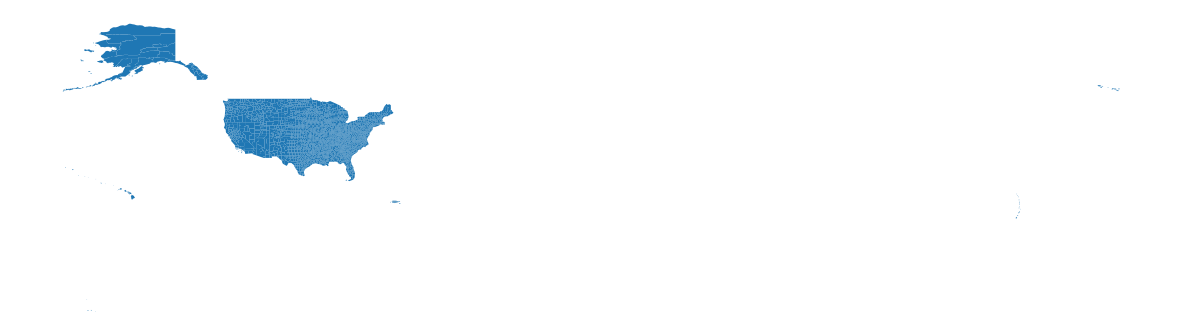

           GEO_ID                     NAME DP03_0001E DP03_0001M DP03_0002E  \
1  0500000US01001  Autauga County, Alabama      47508        227      28020   
2  0500000US01003  Baldwin County, Alabama     195048        457     113778   
3  0500000US01005  Barbour County, Alabama      20253         94       9085   
4  0500000US01007     Bibb County, Alabama      18176         95       9375   
5  0500000US01009   Blount County, Alabama      47389        152      27189   

  DP03_0002M DP03_0003E DP03_0003M DP03_0004E DP03_0004M  ... DP03_0133PM  \
1        890      27070        978      26382        966  ...         1.7   
2       1904     113171       1913     109556       1998  ...         0.9   
3        428       9074        430       8556        440  ...         2.7   
4        492       9375        492       8439        510  ...         2.5   
5        705      27180        706      25594        751  ...         1.6   

  DP03_0134PE DP03_0134PM DP03_0135PE DP03_0135PM DP03_0136PE 

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))
gdf.plot(ax=ax)
ax.set_axis_off()
plt.show()

print(df.head())

print(gdf.columns)
print(gdf.head(2))

I matched the datasets with GEO ID, but the format of GEO ID was different in two datasets so i adjusted for that before merging them.

In [5]:
gdf['GEOID'] = gdf['GEOID'].astype(str)
df['GEO_ID'] = df['GEO_ID'].astype(str)

df['cleaned_GEOID'] = df['GEO_ID'].apply(lambda x: x.split('US')[-1] if 'US' in str(x) else x)

merged_gdf = gdf.merge(df, left_on='GEOID', right_on='cleaned_GEOID')

print(f"Merged Data Shape: {merged_gdf.shape}")
print(merged_gdf.head())

Merged Data Shape: (3222, 571)
  STATEFP COUNTYFP  COUNTYNS  GEOID         GEOIDFQ    NAME_x  \
0      40      075  01101825  40075  0500000US40075     Kiowa   
1      46      079  01265776  46079  0500000US46079      Lake   
2      37      033  01008542  37033  0500000US37033   Caswell   
3      48      377  01383974  48377  0500000US48377  Presidio   
4      39      057  01074041  39057  0500000US39057    Greene   

          NAMELSAD LSAD CLASSFP  MTFCC  ... DP03_0134PE DP03_0134PM  \
0     Kiowa County   06      H1  G4020  ...        23.4         4.6   
1      Lake County   06      H1  G4020  ...         9.2         2.4   
2   Caswell County   06      H1  G4020  ...        16.1         3.8   
3  Presidio County   06      H1  G4020  ...        23.7        12.8   
4    Greene County   06      H1  G4020  ...        10.3         1.0   

  DP03_0135PE DP03_0135PM  DP03_0136PE  DP03_0136PM DP03_0137PE DP03_0137PM  \
0        19.5         6.8         22.3          4.8        37.1         

When I calculated the weights directly, 3 islands and non mainland counties raised a warning. So I decided to use only the mainland US for this analysis and dropped the disconnected components.

In [7]:
w = libpysal.weights.Queen.from_dataframe(merged_gdf, use_index=True)

print(f"Islands found: {w.islands}")
merged_gdf_no_islands = merged_gdf.drop(w.islands)

# 02 = Alaska, 15 = Hawaii, 72 = Puerto Rico
non_mainland_fips = ['02', '15', '72']

merged_gdf_final = merged_gdf_no_islands[~merged_gdf_no_islands['STATEFP'].isin(non_mainland_fips)]


w_clean = libpysal.weights.Queen.from_dataframe(merged_gdf_final, use_index=True)

w_clean.transform = 'r'

print("Weights matrix created without disconnected components.")

/opt/anaconda3/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 3 islands with ids: 929, 1713, 3201.
  W.__init__(self, neighbors, ids=ids, **kw)


Islands found: [929, 1713, 3201]
Weights matrix created without disconnected components.


I selected Median Income, Unemployment Rate, and Poverty Rate (percentage of families below poverty limit) as the variables i wanted to examine. I renamed them for better readability and also checked to make sure all are numeric. I calculated the weights since I also clean NaN rows.

In [11]:
rename_dict = {
    'DP03_0062E': 'Median_Income',
    'DP03_0009PE': 'Unemployment_Rate',
    'DP03_0128PE': 'Poverty_Rate'
}
merged_gdf_final = merged_gdf_final.rename(columns=rename_dict)

cols_to_fix = ['Median_Income', 'Unemployment_Rate', 'Poverty_Rate']

for col in cols_to_fix:
    merged_gdf_final[col] = pd.to_numeric(merged_gdf_final[col], errors='coerce')

merged_gdf_final = merged_gdf_final.dropna(subset=cols_to_fix)

w_final = libpysal.weights.Queen.from_dataframe(merged_gdf_final, use_index=True)
w_final.transform = 'r'

print(merged_gdf_final[['GEOID', 'Median_Income', 'Unemployment_Rate', 'Poverty_Rate']].head())

   GEOID  Median_Income  Unemployment_Rate  Poverty_Rate
0  40075        42063.0                4.3          25.0
1  46079        73792.0                2.4           9.4
2  37033        59407.0                5.7          15.7
3  48377        29014.0               11.1          36.3
4  39057        85218.0                4.0           9.8


I then calculated Moren's I for Median Income. It is 0.61 which suggests strong autocorrelation among counties, and the p-value is significant.

In [12]:
y = merged_gdf_final['Median_Income'].values
moran = Moran(y, w_final)

print(f"Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")

Moran's I: 0.6116685459495298
p-value: 0.001


I ran a spacial regression model with Median Income as my DV and Unemployement and Poverty rates as my IVs.

In [17]:
y_var = merged_gdf_final['Median_Income'].values.reshape((-1, 1))
x_var = merged_gdf_final[['Unemployment_Rate', 'Poverty_Rate']].values

model = ML_Lag(
    y_var, 
    x_var, 
    w=w_final, 
    name_y='Median_Income', 
    name_x=['Unemployment_Rate', 'Poverty_Rate']
)
print(model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Median_Income                Number of Observations:        3107
Mean dependent var  :  65903.7741                Number of Variables   :           4
S.D. dependent var  :  17345.2916                Degrees of Freedom    :        3103
Pseudo R-squared    :      0.7264
Spatial Pseudo R-squared:  0.5460
Log likelihood      : -32837.6162
Sigma-square ML     :82528151.6572                Akaike info criterion :   65683.232
S.E of regression   :   9084.5006                Schwarz criterion     :   65707.398

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------------

The overall model fit looks quite alright with R^2 around 0.73 and Spatial R^2 around 0.55, this shows that model explains a lot of the variation in Median Income, and spatial components also play a considerable role in this explanation. The p_value of W_Median_Income is significant which confirms spatial spillover. The coefficient of 0.58 tells us that all other factors constant, a 1 dollar increase in average income in your neighbour results in a 0.58 dollar increase in your average income. Unemployment rate and Poverty Rate also yielded significant results, where poverty has a negative relationship with median income and unemployment (interestingly, I will look into into) has a positive relaitonship with median income. When we look at the Spatial Lag Model Impacts, we see that Poverty and unemployment rates have also have indirect effects on the neighbouring countries, and it seems even more so compared their direct effect. Poverty rate in neighbouring counties decrease the median income in a country, and unemployment increases it. I can interpret this as a sign of economic interconnectivity but I doubt that indirect effects are actually larger than direct effects.

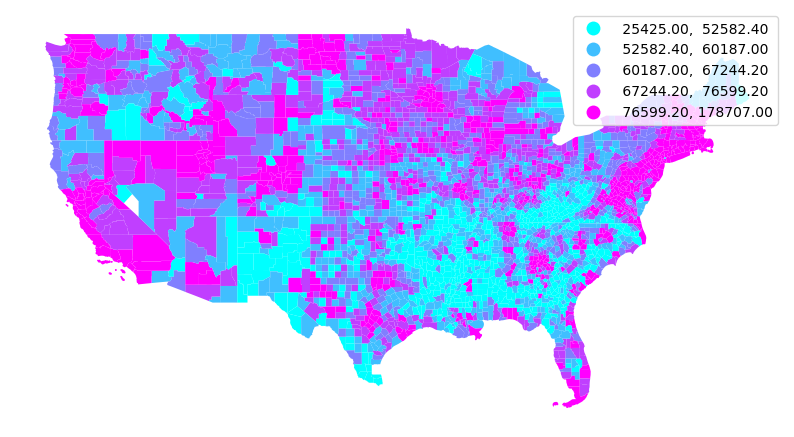

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf_final.plot(column='Median_Income', ax=ax, legend=True, scheme='quantiles', cmap='cool')
plt.axis('off')
plt.show()

Above is the visualization of Median Income on the US mainland map. (I played with the colors for fun.)